# Validation of IEM Mixing Model 
## Goals:
    1. Total system mass must be conserved
    2. Total system enthalpy must be conserved
    3. Mass fractions for each reactor must sum up to 1 at all times. 

In [7]:
# For the Glory of God
# Import required packages and tools: 
from collections import Counter
from cantera import Solution
from cantera._cantera import ConstPressureReactor, ReactorNet
from matplotlib.pyplot import plot, show
import matplotlib.pyplot as plt
from numpy.ma import array, arange
import pandas as pd
import numpy as np

# Create t vector
milliseconds = 0.001;
dt = 0.001*milliseconds;
tau_mix = 0.05*milliseconds;
omega = 1/tau_mix;
end_time = 1*milliseconds;
t = arange(0, end_time, dt)

### Function to Create Reactor Network of Three Reactors: 

In [8]:
def createReactorNetwork():
    m = array([6, 2, 3]);
    s1 = Solution('h2o2.cti');
    s2 = Solution('h2o2.cti');
    s3 = Solution('h2o2.cti');

    s1.TPY = 300, 101325, 'H2:0.75, O2:0.25';
    s2.TPY = [300, 101325, 'O2:0.75, H2:0.25'];
    s3.TPY = [300, 101325, 'H2O:1'];
#     s3.equilibrate('HP');
    tpArray = array([s1, s2, s3])
    
    r1 = ConstPressureReactor(s1);
    r2 = ConstPressureReactor(s2);
    r3 = ConstPressureReactor(s3);
    rArray = array([r1, r2, r3])
    
    rn = ReactorNet([r1, r2, r3]);
    
    r1.syncState(); 
    r2.syncState(); 
    r3.syncState();
    rn.reinitialize()
    return m, tpArray, rArray, rn;

# fuel = Solution('h2o2.cti'); set(fuel, 'T', 300, 'P', 101325, 'Y', 'H2:0.75, O2:0.25'); 
# ox = Solution('h2o2.cti'); set(ox, 'T', 300, 'P', 101325, 'Y', 'O2:0.75, H2:0.25');
# prod = Solution('h2o2.cti'); set(prod, 'T', 300, 'P', 101325, 'Y', 'H2:0.5, O2:0.5');
# equilibrate(prod, 'HP'); 

# sn = speciesNames(fuel); 

# fuelMass = 6; 
# oxMass = 2;
# prodMass = 3; 

### IEM Mixing Model

In [9]:
def iem(m, tpArray, rArray, rn, dt, omega):
# Constant k:
    C_phi = 1;
    k = -C_phi * omega * 0.5 * dt;

# Calculate average: 
    m_total_r = 1/sum(m)
    H_total = 0; 
    M_species_total = array([0.00]*tpArray[0].n_species)
    for i in range(0,len(tpArray)):
        M_species_total += m[i] * tpArray[i].Y; # List of total mass across all reactors of each species
        H_total += m[i] * tpArray[i].enthalpy_mass

    Y_avg = M_species_total * m_total_r # Y_species_avg = (M_total_species)/(M_total_system)
    h_avg = H_total * m_total_r; # H_avg is the specific mass-weighted average across all reactors of the total enthalpy.
#     print(H_total)
# Adjust reactor state:     
    for i in range(0, len(tpArray)):
        h = tpArray[i].enthalpy_mass;
        h_new = h + k * (h - h_avg);
        Y_current = tpArray[i].Y;
        Y_new =  Y_current + k * (Y_current - Y_avg); 
        tpArray[i].HPY = [h_new, tpArray[i].P, Y_new]
        rArray[i].syncState();

# Reinitialize reactor network solver:         
    rn.reinitialize();

## 1. Conservation of Mass: 

In [10]:
m, tpArray, rArray, rn = createReactorNetwork(); 

# Create table
columnNames = ['T'] + ['P'] + ['Enthalpy'] + tpArray[0].species_names 
timeHistory = [pd.DataFrame(columns=columnNames) for i in range(0,len(tpArray))]

counter = 0
for i in range(0, len(t)):
    for j in range(0, len(tpArray)):
        if(counter%10 == 0):        
            state = np.hstack([rArray[j].thermo.T, rArray[j].thermo.P, m[j]*tpArray[j].enthalpy_mass, 
                               rArray[j].thermo.Y])
            timeHistory[j].loc[t[i]] = state
    counter += 1
    iem(m, tpArray, rArray, rn, dt, omega)

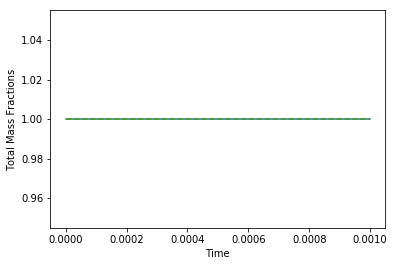

In [11]:
species = tpArray[0].species_names
mf0 = sum([timeHistory[0][species[i]] for i in range(0, len(species))]); 
mf1 = sum([timeHistory[1][species[i]] for i in range(0, len(species))]); 
mf2 = sum([timeHistory[2][species[i]] for i in range(0, len(species))]); 

%matplotlib inline
plt.plot(mf0.index, mf0, label='Reactor 1')
plt.plot(mf1.index, mf1, ':', label='Reactor 2')
plt.plot(mf2.index, mf2, '--', label='Reactor 3')
plt.xlabel('Time');
plt.ylabel('Total Mass Fractions');

In [12]:
# M_species.to_clipboard()

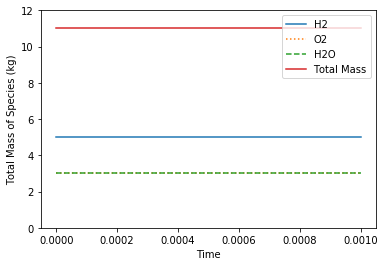

In [13]:
M_species = sum([m[i]*timeHistory[i][species] for i in range(0,len(tpArray))])

%matplotlib inline
plt.plot(M_species.index, M_species['H2'], label='H2')
plt.plot(M_species.index, M_species['O2'], ':', label='O2')
plt.plot(M_species.index, M_species['H2O'], '--', label='H2O')
plt.plot(M_species.index, M_species.sum(1), label='Total Mass')
plt.xlabel('Time');
plt.ylabel('Total Mass of Species (kg)');
plt.legend(); 
plt.ylim(0, 12); 

### Checked: 
- Mass fractions in each reactor sum to 1 at all times 
- Total mass of each reactor stayed constant (by definition) because we're only changing mass fractions 
- Total mass of each species is conserved. 

## 2. Conservation of Energy 

Initial total enthalpy = -40122120.9496 J
Final total enthalpy = -40122120.9496


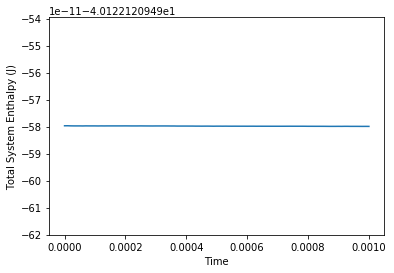

In [14]:
initial_total_enthalpy = timeHistory[0]['Enthalpy'][0] + \
                         timeHistory[1]['Enthalpy'][0] + \
                         timeHistory[2]['Enthalpy'][0]

print("Initial total enthalpy =", initial_total_enthalpy, "J")
print("Final total enthalpy =", sum([timeHistory[i]['Enthalpy'][timeHistory[i].last_valid_index()] for i in range(0, len(tpArray))]))
# H_initial = array([initial_total_enthalpy]*len(t))

h_total = timeHistory[0]['Enthalpy'] + timeHistory[1]['Enthalpy'] + timeHistory[2]['Enthalpy']

%matplotlib inline
plt.plot(h_total.index, h_total/1e6)
plt.xlabel('Time');
plt.ylabel('Total System Enthalpy (J)');

In [15]:
h_total.to_clipboard()

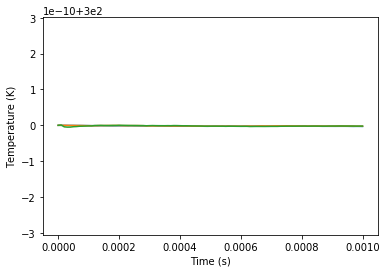

In [16]:
plt.figure()
plt.plot(timeHistory[0].index, timeHistory[0]['T'],
         timeHistory[1].index, timeHistory[1]['T'],
         timeHistory[2].index, timeHistory[2]['T']) 
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)');

In [20]:
timeHistory[2]['T'].to_clipboard(); 
# gas = Solution('h2o2.xml')
# gas.atomic_weights
# 2*gas['H2'].molecular_weights / gas['O2'].molecular_weights
